In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2

np.random.seed(42)
tf.random.set_seed(42)

2023-08-24 14:09:46.071608: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 14:09:46.128927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-24 14:09:46.129773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 14:09:47.709046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!head -20 'Dataset/IAM_words/words_new.txt'

head: 'Dataset/IAM_words/words_new.txt' nem nyitható meg olvasásra: Nincs ilyen fájl vagy könyvtár


# Dataset splitting

Három subset 90:5:5 arányban. (train:validation:test)

In [3]:
base_path = "Dataset/IAM_words/"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [4]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 34474
Total validation samples: 1915
Total test samples: 1916


# Data input pipeline

In [5]:
base_image_path = os.path.join(base_path, "words/")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [6]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  19
Vocab size:  76


['a', ',', 'industry', 'degree', 'part', 'are', 'parties', 'of', '400', '.']

In [7]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

## Character vocabulary

Minták karakter szintű feldolgozása

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

2023-08-24 14:09:49.891867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-24 14:09:49.934843: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [10]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

# Prepare dataset objects

In [11]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

# Samples

2023-08-24 14:09:50.884325: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


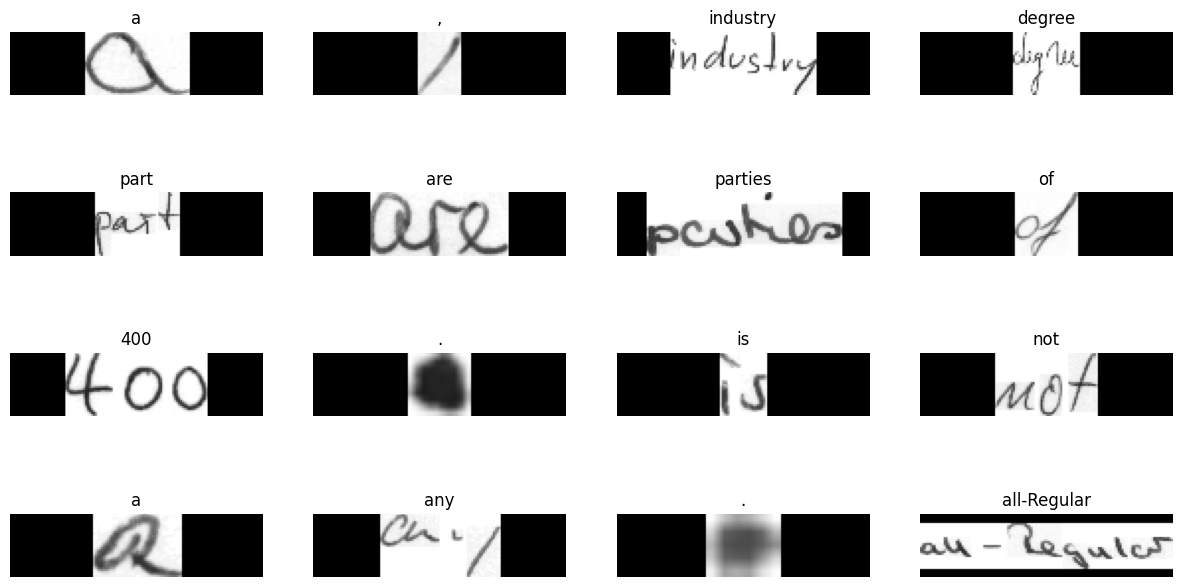

In [12]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

# Model

In [13]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

In [14]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [15]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [16]:
epochs = 50  #this should be at least 50. Use GPU if possible!

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/50


2023-08-24 14:10:03.201788: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


  1/539 [..............................] - ETA: 1:18:02 - loss: 125.6161

2023-08-24 14:10:04.059387: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2023-08-24 14:10:04.118598: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


  2/539 [..............................] - ETA: 3:09 - loss: 117.3160   

2023-08-24 14:10:04.413053: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2023-08-24 14:10:04.470930: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.


2/2 [==============================] - 2s 51ms/step
Mean edit distance for epoch 1: 18.9542
539/539 [==============================] - 211s 376ms/step - loss: 15.5626 - val_loss: 13.9534
Epoch 2/50
2/2 [==============================] - 0s 51ms/step
Mean edit distance for epoch 2: 18.5384
539/539 [==============================] - 186s 345ms/step - loss: 13.0238 - val_loss: 12.4757
Epoch 3/50
2/2 [==============================] - 0s 71ms/step
Mean edit distance for epoch 3: 18.3011
539/539 [==============================] - 191s 355ms/step - loss: 11.8806 - val_loss: 11.1609
Epoch 4/50
2/2 [==============================] - 0s 53ms/step
Mean edit distance for epoch 4: 18.1695
539/539 [==============================] - 192s 356ms/step - loss: 10.8680 - val_loss: 10.1841
Epoch 5/50
2/2 [==============================] - 0s 58ms/step


2/2 [==============================] - 0s 51ms/step
Mean edit distance for epoch 5: 18.0093
539/539 [==============================] - 191s 355ms/step - loss: 10.0679 - val_loss: 9.4773
Epoch 6/50
2/2 [==============================] - 0s 51ms/step
Mean edit distance for epoch 6: 17.8725
539/539 [==============================] - 190s 353ms/step - loss: 9.3610 - val_loss: 8.5969
Epoch 7/50
2/2 [==============================] - 0s 54ms/step
Mean edit distance for epoch 7: 17.6444
539/539 [==============================] - 190s 351ms/step - loss: 8.6419 - val_loss: 7.8079
Epoch 8/50
2/2 [==============================] - 0s 43ms/step
Mean edit distance for epoch 8: 17.3629
539/539 [==============================] - 206s 381ms/step - loss: 7.9173 - val_loss: 7.0010
Epoch 9/50
2/2 [==============================] - 0s 49ms/step
Mean edit distance for epoch 9: 17.0431
539/539 [==============================] - 189s 351ms/step - loss: 7.1771 - val_loss: 6.2106
Epoch 10/50
2/2 [=============

2/2 [==============================] - 0s 47ms/step
Mean edit distance for epoch 10: 16.7668
539/539 [==============================] - 188s 348ms/step - loss: 6.5315 - val_loss: 5.6313
Epoch 11/50
2/2 [==============================] - 0s 71ms/step
Mean edit distance for epoch 11: 16.4957
539/539 [==============================] - 186s 346ms/step - loss: 6.0123 - val_loss: 5.1572
Epoch 12/50
2/2 [==============================] - 0s 47ms/step
Mean edit distance for epoch 12: 16.3234
539/539 [==============================] - 192s 357ms/step - loss: 5.5627 - val_loss: 4.7482
Epoch 13/50
2/2 [==============================] - 0s 52ms/step
Mean edit distance for epoch 13: 16.1988
539/539 [==============================] - 187s 346ms/step - loss: 5.1739 - val_loss: 4.4356
Epoch 14/50
2/2 [==============================] - 0s 47ms/step
Mean edit distance for epoch 14: 16.1463
539/539 [==============================] - 186s 344ms/step - loss: 4.8773 - val_loss: 4.3012
Epoch 15/50
2/2 [=====

2/2 [==============================] - 0s 46ms/step
Mean edit distance for epoch 15: 16.0173
539/539 [==============================] - 186s 344ms/step - loss: 4.6051 - val_loss: 3.9952
Epoch 16/50
2/2 [==============================] - 0s 48ms/step
Mean edit distance for epoch 16: 15.9285
539/539 [==============================] - 185s 342ms/step - loss: 4.3563 - val_loss: 3.7875
Epoch 17/50
2/2 [==============================] - 0s 68ms/step
Mean edit distance for epoch 17: 15.8401
539/539 [==============================] - 185s 344ms/step - loss: 4.1624 - val_loss: 3.6078
Epoch 18/50
2/2 [==============================] - 0s 47ms/step
Mean edit distance for epoch 18: 15.8288
539/539 [==============================] - 185s 343ms/step - loss: 3.9953 - val_loss: 3.5049
Epoch 19/50
2/2 [==============================] - 0s 48ms/step
Mean edit distance for epoch 19: 15.7794
539/539 [==============================] - 183s 339ms/step - loss: 3.8330 - val_loss: 3.3630
Epoch 20/50
2/2 [=====

2/2 [==============================] - 0s 45ms/step
Mean edit distance for epoch 20: 15.7562
539/539 [==============================] - 183s 339ms/step - loss: 3.6960 - val_loss: 3.3512
Epoch 21/50
2/2 [==============================] - 0s 52ms/step
Mean edit distance for epoch 21: 15.7226
539/539 [==============================] - 186s 345ms/step - loss: 3.5691 - val_loss: 3.1996
Epoch 22/50
2/2 [==============================] - 0s 59ms/step
Mean edit distance for epoch 22: 15.6900
539/539 [==============================] - 185s 343ms/step - loss: 3.4649 - val_loss: 3.1855
Epoch 23/50
2/2 [==============================] - 0s 48ms/step
Mean edit distance for epoch 23: 15.7091
539/539 [==============================] - 187s 346ms/step - loss: 3.3400 - val_loss: 3.1217
Epoch 24/50
2/2 [==============================] - 0s 53ms/step


2/2 [==============================] - 0s 46ms/step
Mean edit distance for epoch 24: 15.6760
539/539 [==============================] - 185s 343ms/step - loss: 3.2489 - val_loss: 3.0072
Epoch 25/50
2/2 [==============================] - 0s 51ms/step
Mean edit distance for epoch 25: 15.6894
539/539 [==============================] - 184s 341ms/step - loss: 3.1682 - val_loss: 2.9625
Epoch 26/50
2/2 [==============================] - 0s 47ms/step
Mean edit distance for epoch 26: 15.6635
539/539 [==============================] - 184s 341ms/step - loss: 3.0737 - val_loss: 3.0165
Epoch 27/50
2/2 [==============================] - 0s 49ms/step
Mean edit distance for epoch 27: 15.6445
539/539 [==============================] - 185s 343ms/step - loss: 3.0059 - val_loss: 2.9143
Epoch 28/50
2/2 [==============================] - 0s 55ms/step
Mean edit distance for epoch 28: 15.5907
539/539 [==============================] - 185s 343ms/step - loss: 2.9203 - val_loss: 2.7918
Epoch 29/50
2/2 [=====

2/2 [==============================] - 0s 46ms/step
Mean edit distance for epoch 29: 15.6372
539/539 [==============================] - 183s 340ms/step - loss: 2.8643 - val_loss: 2.8305
Epoch 30/50
2/2 [==============================] - 0s 52ms/step
Mean edit distance for epoch 30: 15.5820
539/539 [==============================] - 184s 341ms/step - loss: 2.8032 - val_loss: 2.7174
Epoch 31/50
2/2 [==============================] - 0s 49ms/step
Mean edit distance for epoch 31: 15.5502
539/539 [==============================] - 185s 343ms/step - loss: 2.7342 - val_loss: 2.7131
Epoch 32/50
2/2 [==============================] - 0s 49ms/step
Mean edit distance for epoch 32: 15.5499
539/539 [==============================] - 186s 345ms/step - loss: 2.6927 - val_loss: 2.7339
Epoch 33/50
2/2 [==============================] - 0s 55ms/step
Mean edit distance for epoch 33: 15.5358
539/539 [==============================] - 186s 344ms/step - loss: 2.6257 - val_loss: 2.6238
Epoch 34/50
2/2 [=====

2/2 [==============================] - 0s 47ms/step
Mean edit distance for epoch 34: 15.5292
539/539 [==============================] - 185s 344ms/step - loss: 2.5831 - val_loss: 2.5766
Epoch 35/50
2/2 [==============================] - 0s 48ms/step
Mean edit distance for epoch 35: 15.5163
539/539 [==============================] - 181s 336ms/step - loss: 2.5162 - val_loss: 2.6128
Epoch 36/50
2/2 [==============================] - 0s 46ms/step
Mean edit distance for epoch 36: 15.5878
539/539 [==============================] - 183s 340ms/step - loss: 2.5130 - val_loss: 2.8302
Epoch 37/50
2/2 [==============================] - 0s 47ms/step
Mean edit distance for epoch 37: 15.5618
539/539 [==============================] - 184s 341ms/step - loss: 2.4600 - val_loss: 2.6058
Epoch 38/50
2/2 [==============================] - 0s 48ms/step
Mean edit distance for epoch 38: 15.5032
539/539 [==============================] - 184s 342ms/step - loss: 2.4096 - val_loss: 2.5295
Epoch 39/50
2/2 [=====

2/2 [==============================] - 0s 55ms/step
Mean edit distance for epoch 39: 15.4854
539/539 [==============================] - 183s 340ms/step - loss: 2.3782 - val_loss: 2.5564
Epoch 40/50
2/2 [==============================] - 0s 49ms/step
Mean edit distance for epoch 40: 15.4832
539/539 [==============================] - 185s 343ms/step - loss: 2.3372 - val_loss: 2.5412
Epoch 41/50
2/2 [==============================] - 0s 48ms/step
Mean edit distance for epoch 41: 15.5134
539/539 [==============================] - 184s 342ms/step - loss: 2.2807 - val_loss: 2.6247
Epoch 42/50
2/2 [==============================] - 0s 45ms/step
Mean edit distance for epoch 42: 15.4956
539/539 [==============================] - 187s 347ms/step - loss: 2.2632 - val_loss: 2.5890
Epoch 43/50
2/2 [==============================] - 0s 54ms/step


2/2 [==============================] - 0s 46ms/step
Mean edit distance for epoch 43: 15.4891
539/539 [==============================] - 199s 370ms/step - loss: 2.2384 - val_loss: 2.5516
Epoch 44/50
2/2 [==============================] - 0s 48ms/step
Mean edit distance for epoch 44: 15.5068
539/539 [==============================] - 186s 345ms/step - loss: 2.2438 - val_loss: 2.5475
Epoch 45/50
2/2 [==============================] - 0s 47ms/step
Mean edit distance for epoch 45: 15.4845
539/539 [==============================] - 186s 346ms/step - loss: 2.1524 - val_loss: 2.4845
Epoch 46/50
2/2 [==============================] - 0s 47ms/step
Mean edit distance for epoch 46: 15.4574
539/539 [==============================] - 186s 345ms/step - loss: 2.1446 - val_loss: 2.4027
Epoch 47/50
2/2 [==============================] - 0s 54ms/step
Mean edit distance for epoch 47: 15.4645
539/539 [==============================] - 186s 345ms/step - loss: 2.1168 - val_loss: 2.4747
Epoch 48/50
2/2 [=====

2/2 [==============================] - 0s 49ms/step
Mean edit distance for epoch 48: 15.4562
539/539 [==============================] - 186s 345ms/step - loss: 2.0900 - val_loss: 2.3903
Epoch 49/50
2/2 [==============================] - 0s 49ms/step
Mean edit distance for epoch 49: 15.4508
539/539 [==============================] - 187s 348ms/step - loss: 2.0647 - val_loss: 2.4093
Epoch 50/50
2/2 [==============================] - 0s 53ms/step
Mean edit distance for epoch 50: 15.4514
539/539 [==============================] - 187s 346ms/step - loss: 2.0428 - val_loss: 2.4874


2023-08-24 16:46:59.215311: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2/2 [==============================] - 0s 57ms/step


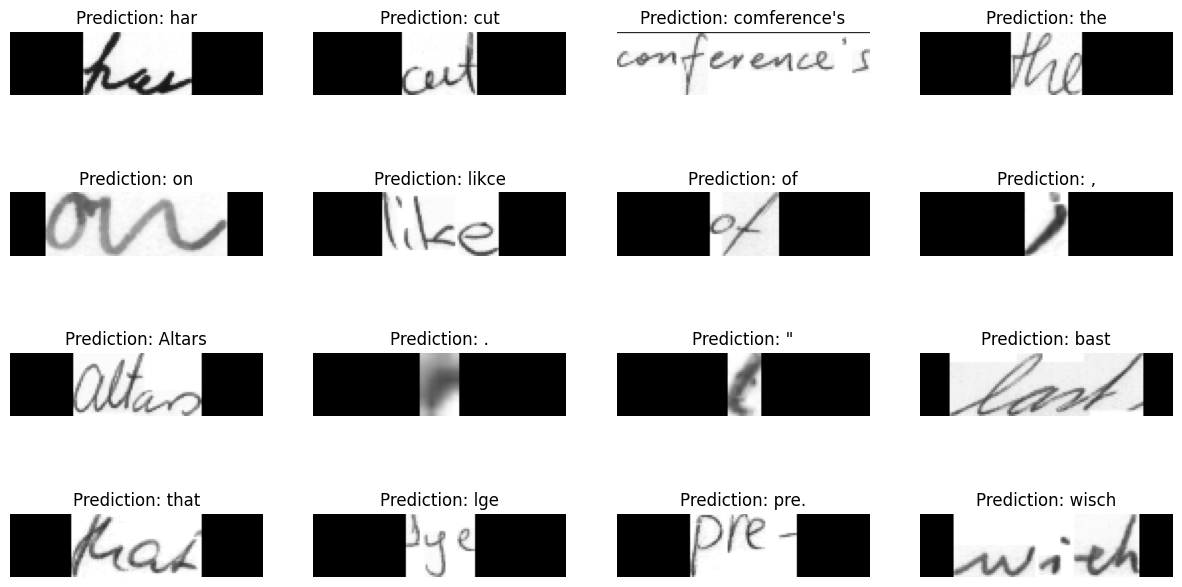

In [17]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [18]:
model.save('Data/model/')

INFO:tensorflow:Assets written to: Data/model/assets


INFO:tensorflow:Assets written to: Data/model/assets
